In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import *
import tensorflow as tf

In [3]:
df=pd.read_csv('/Users/poonkuzhali.saran/PycharmProjects/emorec/sentiment_model/isear/isear_dataset.csv')
df.head()

,ID,sentiment,content
0,10941,anger,At the point today where if someone says somet...
1,10942,anger,@CorningFootball IT'S GAME DAY!!!! T MIN...
2,10943,anger,This game has pissed me off more than any othe...
3,10944,anger,@spamvicious I've just found out it's Candice ...
4,10945,anger,@moocowward @mrsajhargreaves @Melly77 @GaryBar...


In [4]:
Sentences = df['content']
Sentiments = df['sentiment']

In [5]:
len(Sentences), len(Sentiments)

(7102, 7102)

In [6]:
glove ='/Users/poonkuzhali.saran/PycharmProjects/emorec/sentiment_model/isear/glove.6B.50d.txt'

def load_glove_embeddings(path):
    embeddings_index = {}
    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

Glove = load_glove_embeddings(glove)

In [7]:
def cosine_similarity(a, b):
    """
    Computes the cosine similarity between two vectors a and b.
    """
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

Tomato = Glove['tomato']
Soup = Glove['soup']

cosine_similarity(Tomato, Soup)

0.85103494

In [8]:
def preprocess(Sentences):
    sentences = tf.strings.substr(Sentences, 0, 300)
    sentences = tf.strings.regex_replace(sentences, b"<br\\s*/?>", b" ")
    sentences = tf.strings.regex_replace(sentences, b"[^a-zA-Z']", b" ")
    sentences = tf.strings.split(sentences)
    sentences = tf.strings.lower(sentences)
    sentences = sentences.to_tensor(default_value=b"<pad>")
    return sentences

In [9]:
sentences = preprocess(Sentences)
sentences.shape

TensorShape([7102, 34])

In [10]:
def encoding(sentences, Glove):
    Encoded_vec = []
    for sentence in sentences:
        sent_vec = []
        for token in sentence:
            token = token.numpy().decode('utf-8')
            if token in Glove:
                sent_vec.append(Glove[token])
            else:
                sent_vec.append(np.zeros(50))
        Encoded_vec.append(sent_vec)
    return Encoded_vec

In [11]:
Encoded_vec = encoding(sentences, Glove)
X = np.array(Encoded_vec)
print(X.shape)

(7102, 34, 50)


In [12]:
enc = OneHotEncoder(handle_unknown='ignore')
Y = enc.fit_transform(np.array(Sentiments).reshape(-1,1)).toarray()
print(Y.shape)

(7102, 4)


In [13]:
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=23)

In [14]:
class BiLSTMModel:
    def __init__(self):
        self.model = Sequential()
        self.model.add(Bidirectional(LSTM(100, input_shape=(100, 50))))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(4, activation='softmax'))
        self.model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    def fit(self, X, Y, epochs, batch_size):
        self.model.fit(X, Y, epochs=epochs, batch_size=batch_size)

    def evaluate(self, X, Y, batch_size):
        return self.model.evaluate(X, Y, batch_size=batch_size)

    def predict(self, X):
        return self.model.predict(X)

In [15]:
model = BiLSTMModel()

model.fit(X_train,Y_train, epochs=20, batch_size=64)

Epoch 1/20
89/89 [==============================] - 3s 21ms/step - loss: 1.2780 - accuracy: 0.4017
Epoch 2/20
89/89 [==============================] - 4s 41ms/step - loss: 1.1172 - accuracy: 0.5092
Epoch 3/20
89/89 [==============================] - 3s 38ms/step - loss: 1.0342 - accuracy: 0.5673
Epoch 4/20
89/89 [==============================] - 3s 32ms/step - loss: 0.9284 - accuracy: 0.6164
Epoch 5/20
89/89 [==============================] - 3s 31ms/step - loss: 0.8370 - accuracy: 0.6648
Epoch 6/20
89/89 [==============================] - 2s 28ms/step - loss: 0.7677 - accuracy: 0.6927
Epoch 7/20
89/89 [==============================] - 2s 27ms/step - loss: 0.6729 - accuracy: 0.7381
Epoch 8/20
89/89 [==============================] - 3s 29ms/step - loss: 0.6173 - accuracy: 0.7664
Epoch 9/20
89/89 [==============================] - 3s 30ms/step - loss: 0.5590 - accuracy: 0.7831
Epoch 10/20
89/89 [==============================] - 3s 33ms/step - loss: 0.5011 - accuracy: 0.8109
Epoch 11/

In [16]:
model.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 200)               120800    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 4)                 804       
                                                                 
Total params: 121604 (475.02 KB)
Trainable params: 121604 (475.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


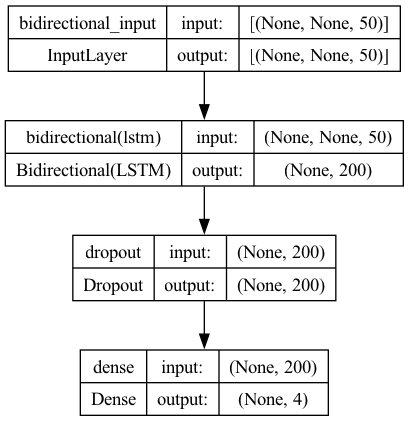

In [21]:
from keras.utils import plot_model
plot_model(model.model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [19]:
Loss, acc = model.evaluate(X_test, Y_test, batch_size=64)
print("Loss: %.2f" % (Loss))
print("acc: %.2f" % (acc))

23/23 [==============================] - 1s 19ms/step - loss: 0.7898 - accuracy: 0.7544
Loss: 0.79
acc: 0.75


In [20]:
twt = ['Nothing is more relentless than a dog begging for food']
Twt = preprocess(twt)

Twt = encoding(Twt, Glove)
Twt = np.array(Twt)
print(Twt.shape)
sentiment = model.predict(Twt)[0]
label = np.argmax(sentiment)
enc.categories_[0][label]

(1, 10, 50)
1/1 [==============================] - 0s 379ms/step


'fear'